# Jeopardy winning pattern

## Introduction

In this project I am going to analyse Jeopardy question dataset containing all the questions from 1984 to 2012. The dataset can be found under this [link](https://www.kaggle.com/tunguz/200000-jeopardy-questions). I am going to check:
- how often the answer can be guessed from the question
- if any questions were repeated 
- if any specific words are repeat, if so, how often
- the most frequent category and the probability of that category occuring in the game
- calculating Chi squared statistic to check if there are any words with significant different appearance in high value questions.

### Summary of results

- Some answers occur in questions but there is less then 1% of them.
- The most frequent word *Country* occurs almost 3 times per 100 questions. 
- There is over 63% chance of getting at least once in the game the question of category Before&After.
- There is around 505 words which are most likely to occur in high value questions.

## Data exploration

In [1]:
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import pandas as pd
import difflib
import string
import nltk
import re
%matplotlib inline

In [2]:
jeopardy = pd.read_csv('data//jeopardy_full.csv',parse_dates=[' Air Date'])

In [3]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [4]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
Show Number    216930 non-null int64
 Air Date      216930 non-null datetime64[ns]
 Round         216930 non-null object
 Category      216930 non-null object
 Value         216930 non-null object
 Question      216930 non-null object
 Answer        216928 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 11.6+ MB


Some columns have wrong datatype and there is a white space in front of some column names. Lets clean this.

## Data cleaning

In [5]:
# removing white space from coulmn names
jeopardy.rename({' Air Date':'Air Date',' Round':'Round',' Category':'Category',' Value':'Value',' Question':'Question',' Answer':'Answer' },axis=1,inplace=True)

# sorting rows by date
jeopardy_sorted = jeopardy.sort_values(['Air Date']).reset_index(drop=True)

## Question repeated

In [6]:
past_questions = jeopardy_sorted['Question']
past_answers = jeopardy_sorted['Answer']
def repeated_check(row):
    index = row.name
    for ind, que in enumerate(past_answers[:index]):
        if difflib.SequenceMatcher(None, str(row['Answer']), str(que)).ratio()>0.9:
            if difflib.SequenceMatcher(None, str(row['Question']), str(past_questions[ind])).ratio()>0.6:
                return 1
        else:
            return 0   
    
jeopardy_sorted['repeated'] = jeopardy_sorted.apply(repeated_check,axis=1)

In [7]:
jeopardy_sorted['repeated'].value_counts()

0.0    216929
Name: repeated, dtype: int64

We have checked match between each answer and all answers in the past if there was any matching then we compared their questions if they were also more-less matching it might mean that the question was repeated. Unfortunately we got 0 repeated questions. Then we know that we need to find another way to analyse this dataset. Lets now clean *Questions* and *Answer* column to remove punctuation and make all lowercase words.

## Data cleaning cont.

In [8]:
# creating subset of data
jeopardy_clean = jeopardy_sorted.iloc[:,:4].copy()

# transforming data in Value column
jeopardy_clean['clean_value'] = (jeopardy_sorted['Value'].str.replace(',','').str.replace('$','').str.replace('None','0')).astype(int)

In order to compare questions and answers between different shows we need to remove punctuation and stop words. We can use nltk to do that.

In [9]:
# useless words
punctuation = string.punctuation
stop_words = nltk.corpus.stopwords.words("english")

# removing punctiation and stopwords
def normalize_text(col):
    bag_of_words = nltk.word_tokenize(str(col))
    bag_of_words_clean = []
    for word in bag_of_words:
        word = word.lower().strip()
        bag_of_words_clean.append(re.sub(r'[{}]+'.format(re.escape(punctuation)),'',word))
    while '' in bag_of_words_clean:
        bag_of_words_clean.remove('')  
    for word in stop_words:
        while word in bag_of_words_clean:
            bag_of_words_clean.remove(word)
    return ' '.join(bag_of_words_clean)

jeopardy_clean['clean_question'] =  jeopardy_sorted['Question'].apply(normalize_text)
jeopardy_clean['clean_answer'] =  jeopardy_sorted['Answer'].apply(normalize_text)

In [10]:
jeopardy_clean

,Show Number,Air Date,Round,Category,clean_value,clean_question,clean_answer
0,1,1984-09-10,Jeopardy!,LAKES & RIVERS,100,river mentioned often bible,jordan
1,1,1984-09-10,Double Jeopardy!,THE BIBLE,1000,according 1st timothy root evil,love money
2,1,1984-09-10,Double Jeopardy!,'50'S TV,1000,name experimenter herbert taught viewers science,mr wizard
3,1,1984-09-10,Double Jeopardy!,NATIONAL LANDMARKS,1000,dc building shaken november 83 bomb blast,capitol
4,1,1984-09-10,Double Jeopardy!,NOTORIOUS,1000,deed leaped stage shouting sic semper tyrannis,john wilkes booth
...,...,...,...,...,...,...,...
216925,6300,2012-01-27,Jeopardy!,VISITING THE CITY,800,great opera house bennelong point see fort den...,sydney
216926,6300,2012-01-27,Jeopardy!,PANTS,1400,tightfitting pants patterned worn bullfighters...,toreador pants
216927,6300,2012-01-27,Jeopardy!,CHILD ACTORS,800,kid familiar last name seen href http wwwjarch...,jaden smith
216928,6300,2012-01-27,Jeopardy!,LESSER-KNOWN SCIENTISTS,800,joseph lagrange insisted 10 basic unit standar...,metric system


## Analysis

In order to find what to study we are going to find two thinks:
- how often the answer can be guessed from the question,
- the most frequent category,
- if any specific words are repeat, if so, how often,
- if any word is more likely to occur in the high value question vs low value one.

### Answer hidden in question
Lets start by analysing the first problem.

In [11]:
# answer present in questions

def question_answer(row):
    if type(row['clean_answer']) == float:
        answer = str(row['clean_answer'])
    else:
        answer = row['clean_answer']
    split_answer = answer.split()
    split_question = row['clean_question'].split()
    match_count = 0
    if len(split_answer) == 0:
        return 0
    for word in split_answer:
        if word in split_question:
            match_count +=1
    return match_count/len(split_answer)

In [12]:
jeopardy_clean['answer_in_question'] = jeopardy_clean.apply(question_answer,axis=1)

% of questions with easy to guess answers: 0.007


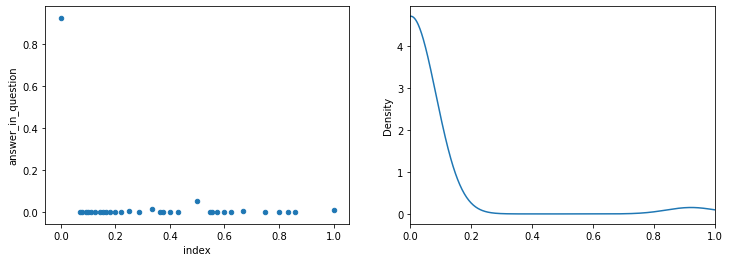

In [13]:
ax = plt.subplot(1,2,1)
ax = jeopardy_clean['answer_in_question'].value_counts(normalize=True).sort_index(ascending=False).reset_index().plot.scatter(x='index',y='answer_in_question',ax=ax,figsize=(12,4))
ax =plt.subplot(1,2,2)
ax = jeopardy_clean['answer_in_question'].value_counts(normalize=True).sort_index(ascending=False).plot.kde()
ax.set_xlim(0,1)

print('% of questions with easy to guess answers: ' + str(round((jeopardy_clean[jeopardy_clean['answer_in_question'] == 1]['answer_in_question'].sum()) / jeopardy_clean.shape[0],4)))

We have found that indeed some answers occur in questions but there is less then 1% of them. It won't be a good tactic to relay on it.

### The most frequent category

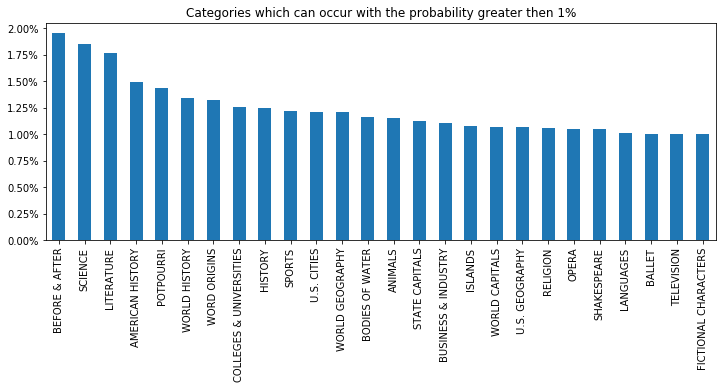

In [14]:
# categories frequency
categories = jeopardy_clean['Category'].value_counts()

# categories occurrence probability
categories_probability = categories/jeopardy_clean['Category'].unique().size

ax = categories_probability[categories_probability>0.01].plot.bar(figsize=(12,4),title='Categories which can occur with the probability greater then 1%')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

In [15]:
# probablity that one of this question will occur 
p_one_of_26 = categories_probability[categories_probability>0.01].sum()

# number of questions per game
questions_per_game = jeopardy_clean.groupby('Show Number').agg('size').value_counts(normalize=True).sort_index(ascending=False)

# number of questions with 95% confidence  
questions_95 = questions_per_game[1:8].index[-1]
p_n_question = questions_per_game[1:8].sum()

There is 7 values between 61 - 55 which are possible number of questions per game which occur most often. There is 95% probability that the number of question in game is equal to one of this value. Lets calculate the probability of getting at least once one of the 26 category question in the game.

In [16]:
(1 - (1-p_one_of_26)**questions_95)*p_n_question

0.9576923072227937

There is almost 96% chance of getting one of the above category question in the game.

In [17]:
(1 - (1-categories_probability[0])**questions_95)*p_n_question

0.6341814760738123

There is over 63% chance of getting at least once in the game the question of category Before&After.

### Frequent phrases

Lets now check what are the most frequent phrases.

In [18]:
terms_used = []

for index, row in jeopardy_clean.iterrows():
    split_question = row['clean_question'].split()
    for word in split_question:
        if len(str(word)) > 6:
            terms_used.append(word)

In [19]:
pd.Series(terms_used).value_counts().head(15)/jeopardy_clean.shape[0]

country       0.027714
president     0.014959
capital       0.013267
american      0.013193
company       0.009823
national      0.009150
british       0.008980
largest       0.008957
character     0.008588
century       0.008468
meaning       0.007242
founded       0.006859
include       0.006495
america       0.006219
university    0.006131
dtype: float64

Here we can see the most frequent words which occur in questions. The most frequent one *Country* occurs almost 3 times per 100 questions.

### High value questions


In [20]:
# high and low value questions
def value_question(row):
    if row['clean_value'] > 800:
        return 1
    else:
        return 0

In [21]:
jeopardy_clean['high_value'] = jeopardy_clean.apply(value_question,axis=1)

In [22]:
jeopardy_clean.head()

,Show Number,Air Date,Round,Category,clean_value,clean_question,clean_answer,answer_in_question,high_value
0,1,1984-09-10,Jeopardy!,LAKES & RIVERS,100,river mentioned often bible,jordan,0.0,0
1,1,1984-09-10,Double Jeopardy!,THE BIBLE,1000,according 1st timothy root evil,love money,0.0,1
2,1,1984-09-10,Double Jeopardy!,'50'S TV,1000,name experimenter herbert taught viewers science,mr wizard,0.0,1
3,1,1984-09-10,Double Jeopardy!,NATIONAL LANDMARKS,1000,dc building shaken november 83 bomb blast,capitol,0.0,1
4,1,1984-09-10,Double Jeopardy!,NOTORIOUS,1000,deed leaped stage shouting sic semper tyrannis,john wilkes booth,0.0,1


We have added a new column *high value* if value of the question in more then 800$ then the colum contains 1 otherwise 0.

### Chi squared test

In [62]:
high_value_words = ' '.join(jeopardy_clean.loc[jeopardy_clean['high_value']==1,'clean_question'])
low_value_words = ' '.join(jeopardy_clean.loc[jeopardy_clean['high_value']==0,'clean_question'])

high_value_list = high_value_words.split()
low_value_list = low_value_words.split()

high_value_dict = {}

for word in high_value_list:
    if word in high_value_dict:
        high_value_dict[word]+=1
    else:
        high_value_dict[word]=1
    
low_value_dict = {}

for word in low_value_list:
    if word in low_value_dict:
        low_value_dict[word]+=1
    else:
        low_value_dict[word]=1

In [63]:
observed_high_low = []

comparision_terms = list(set(terms_used))

for word in comparision_terms:
    if word in high_value_dict:
        high_count = high_value_dict[word]
    else:
        high_count = 0
        
    if word in low_value_dict:
        low_count = low_value_dict[word]
    else:
        low_count = 0 
    observed_high_low.append((high_count,low_count))

In [87]:
observed_high_low[:10]

[(0, 1),
 (0, 6),
 (3, 12),
 (3, 12),
 (2, 0),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (3, 16)]

In [89]:
high_value_count = jeopardy_clean['high_value'].sum()
low_value_count = jeopardy_clean['high_value'].size - high_value_count

chi_squared = []

for each in observed_high_low:
    # to consider only high value question
    if each[0] > each[1]:
        total = sum(each)
        total_prop = total / jeopardy.shape[0]
        high_expected = total_prop * high_value_count
        low_expected = total_prop * low_value_count
        expected = (high_expected,low_expected)
        chi_stat, p_val = chisquare(each,expected)
        chi_squared.append(p_val)

Lets check if any of the terms had a significant difference in usage between high value and low value rows taking alpha level=0.01. 

In [90]:
p_val = pd.Series(chi_squared)
in_critical_region = p_val[p_val<0.01].index
significant_different = pd.Series(list(set(terms_used)))[in_critical_region]

In [94]:
significant_different

3               misfits
83             powermac
86             jokanaan
152      impersonations
193          passionant
              ...      
19054           flashes
19113          marsters
19262          elastica
19302          midterms
19328          arjumand
Length: 505, dtype: object

## Conclusion

Comparing the sequences of questions using an algorithm named *gestalt pattern matching* I didn't find any repeated question. But future analysis are required to confirm that.

Discovered facts:
- Some answers occur in questions but there is less then 1% of them.
- The most frequent word *Country* occurs almost 3 times per 100 questions. 
- There is over 63% chance of getting at least once in the game the question of category Before&After.
- There is around 505 words which are most likely to occur in high value questions.